# A compact A/B testing notebook — EDA + Core Tests

This notebook contains a concise, practical workflow I used to evaluate a marketing A/B test. It focuses on the minimal, statistically sound steps needed to decide whether a campaign moved the primary KPI (conversion rate). I include brief notes and in-place interpretations to make the analysis easy to follow.

**Assumptions**
- Unit of analysis is the user. If your raw data has multiple events per user, aggregate first.
- Expected columns: `user_id`, `test_group` (values `A` and `B`).

---

In [1]:
# Imports and display settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats import proportion as smp
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

pd.options.display.max_columns = 200
sns.set(style='whitegrid')

## 1) Load data 



In [29]:
DATA_PATH = '../data/marketing_AB.csv'  
df_orgnl = pd.read_csv(DATA_PATH)
print('Loaded:', DATA_PATH)
display(df.head())

Loaded: ../data/marketing_AB.csv


,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


## 2) Preprocess & sanity checks

Ensure a single row per user.

In [30]:
df = df_orgnl
print(df.describe())
print(df.info())

          Unnamed: 0       user id      total ads  most ads hour
count  588101.000000  5.881010e+05  588101.000000  588101.000000
mean   294050.000000  1.310692e+06      24.820876      14.469061
std    169770.279668  2.022260e+05      43.715181       4.834634
min         0.000000  9.000000e+05       1.000000       0.000000
25%    147025.000000  1.143190e+06       4.000000      11.000000
50%    294050.000000  1.313725e+06      13.000000      14.000000
75%    441075.000000  1.484088e+06      27.000000      18.000000
max    588100.000000  1.654483e+06    2065.000000      23.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int6

In [31]:
#Missing values
print( df.isnull().sum() )

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64


In [35]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
# Rename columns for easier access
df.rename(columns ={
    'user id':'user_id',
    'test group':'test_group',
    'total ads':'total_ads',
    'most ads day':'most_ads_day',
    'most ads hour':'most_ads_hour'},inplace=True)

In [36]:
def filter_outliers(data , whisker =1.5):

    #q1 and q3
    Q1 = data.quantile(0.25) #25th percentile
    Q3= data.quantile(0.57)  #75th percentile
    IQR = Q3-Q1
    lower_bound = Q1-whisker*IQR
    upper_bound = Q3+whisker*IQR

    is_outlier = data[(data< lower_bound) | (data > upper_bound)]

    return is_outlier



In [37]:
outliers = filter_outliers(df['total_ads'])
print(f""" \t   Total no. of  outliers : {len(outliers)}
           Total no. of records : {len(df)}
           Percentage of outliers : {len(outliers) * 100/len(df) :.2f}%""")

 	   Total no. of  outliers : 112495
           Total no. of records : 588101
           Percentage of outliers : 19.13%




## 2) Conversion summary and simple plots.

In [18]:
user_df = (df.groupby('user_id')
                 .agg(test_group=('test_group','first'),
                      converted=('converted','max'))
                 .reset_index())
if 'revenue' in df.columns:
    rev = df.groupby('user_id').revenue.sum().reset_index()
    user_df = user_df.merge(rev, on='user_id', how='left')

print('\nTotal users:', len(user_df))
display(user_df.groupby('test_group').agg(n_users=('user_id','count'), conversions=('converted','sum')))
print('\nMissing values:')
display(user_df.isna().sum())


Total users: 588101


,n_users,conversions
test_group,,
ad,564577,14423
psa,23524,420



Missing values:


user_id       0
test_group    0
converted     0
dtype: int64

,conv_rate,sum,count
test_group,,,
ad,0.025547,14423,564577
psa,0.017854,420,23524


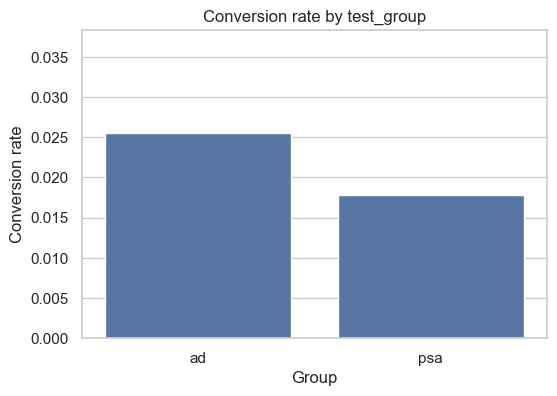

In [19]:
if not user_df.empty:
    conv_by_group = user_df.groupby('test_group').converted.agg(['mean','sum','count']).rename(columns={'mean':'conv_rate'})
    display(conv_by_group)

    plt.figure(figsize=(6,4))
    sns.barplot(x=conv_by_group.index, y=conv_by_group['conv_rate'].values)
    plt.title('Conversion rate by test_group')
    plt.ylabel('Conversion rate')
    plt.xlabel('Group')
    plt.ylim(0, conv_by_group['conv_rate'].max()*1.5)
    plt.show()

    if 'revenue' in user_df.columns:
        plt.figure(figsize=(10,4))
        sns.boxplot(x='test_group', y='revenue', data=user_df)
        plt.title('Revenue per user by test_group')
        plt.show()

## 4) Main test — two-proportion z-test (conversion rate)

Purpose: test whether conversion rate differs between groups.

##### Hypotheses and Definitions

**Definitions:**
- **p<sub>A</sub>** — True conversion rate (probability of conversion) for **Group A** (Control).
- **p<sub>B</sub>** — True conversion rate for **Group B** (Treatment or Campaign group).
- **H₀ (Null Hypothesis):** There is **no difference** between the two groups. Any observed difference is due to random chance.
- **H₁ (Alternative Hypothesis):** There **is a difference** between the two groups — meaning the campaign had a real effect.

**Formally:**
\[
H_0 : p_A = p_B
\]
\[
H_1 : p_A != p_B
\]

**Interpretation:**
- If **p-value < 0.05**, reject H₀ → the campaign had a statistically significant effect.
- If **p-value ≥ 0.05**, fail to reject H₀ → no sufficient evidence of campaign impact.


In [38]:
if not user_df.empty:
    grouped = user_df.groupby('test_group').converted.agg(['sum','count']).rename(columns={'sum':'successes','count':'n'})
    display(grouped)

    successes = grouped['successes'].values
    nobs = grouped['n'].values

    z_stat, p_value = smp.proportions_ztest(successes, nobs, alternative='two-sided')

    pA = successes[0]/nobs[0]
    pB = successes[1]/nobs[1]
    diff = pB - pA
    se = np.sqrt(pA*(1-pA)/nobs[0] + pB*(1-pB)/nobs[1])
    ci_low = diff - 1.96*se
    ci_high = diff + 1.96*se

    print(f"p_A = {pA:.4f}, p_B = {pB:.4f}")
    print(f"Difference (B - A) = {diff:.4f}")
    print(f"z = {z_stat:.3f}, p = {p_value:.4g}")
    print(f"95% CI for difference = [{ci_low:.4f}, {ci_high:.4f}]")

    if p_value < 0.05:
        print('\nConclusion: Significant difference at alpha=0.05.')
    else:
        print('\nConclusion: No significant difference at alpha=0.05.')

,successes,n
test_group,,
ad,14423,564577
psa,420,23524


p_A = 0.0255, p_B = 0.0179
Difference (B - A) = -0.0077
z = 7.370, p = 1.705e-13
95% CI for difference = [-0.0094, -0.0060]

Conclusion: Significant difference at alpha=0.05.


## 5)  Effect Size — Measuring Business Impact

**What we are doing:**  
After finding a statistically significant difference, we calculate how **big** that difference is in practical terms.  
This step measures the **absolute difference** and **relative lift** between the treatment (B) and control (A) groups.

**Definitions:**
- **Absolute Difference (diff)** — The direct difference in conversion rates between groups (pB - pA).  
- **Relative Lift (%)** — The percentage improvement of Group B over Group A, showing how much the campaign increased conversions relative to the baseline.

**Why it matters:**  
Statistical significance alone doesn’t tell us if the improvement is **meaningful for the business**.  
Effect size helps translate the result into actionable terms — e.g., a *2% absolute lift* might be statistically small but could still drive major revenue impact at scale.


In [22]:
if not user_df.empty:
    abs_diff = diff
    pct_lift = (diff / pA) * 100 if pA != 0 else np.nan
    print(f"Absolute difference: {abs_diff:.4f}")
    print(f"Relative lift (B vs A): {pct_lift:.2f}%")

Absolute difference: -0.0077
Relative lift (B vs A): -30.11%


In [40]:
user_df.columns.tolist()

['user_id', 'test_group', 'converted']

### 6) Conversion Rate Comparison (Control vs Treatment)

This section measures whether the experimental advertisement led to a different conversion rate compared to the control (PSA).

Steps performed below:
1. Group the dataset by `test_group` and calculate:
   - total **successes** (number of conversions),
   - total **n** (number of observations per group).
2. Compute conversion rates for each group.
3. Run a **two-proportion z-test** to test if the difference between conversion rates is statistically significant.

The printed output includes:
- conversion rates for the control (`psa`) and treatment (`ad`) groups, and  
- the z-statistic and p-value from the test.

**Interpretation:**
If the p-value is less than 0.05, we reject the null hypothesis and conclude that the treatment (ad) produced a statistically significant difference in conversion rate compared to the control.


In [ ]:
grouped = user_df.groupby('test_group').converted.agg(['sum','count']).rename(columns={'sum':'successes','count':'n'})
display(grouped)
succ = grouped['successes']
nobs = grouped['n']

control_label, treat_label = 'psa', 'ad'
successes = [int(grouped.loc[control_label,'successes']), int(grouped.loc[treat_label,'successes'])]
nobs = [int(grouped.loc[control_label,'n']), int(grouped.loc[treat_label,'n'])]

z_stat, p_value = smp.proportions_ztest(successes, nobs, alternative='two-sided')
p_control = successes[0]/nobs[0]
p_treat = successes[1]/nobs[1]
print(f"control ({control_label}) rate = {p_control:.4f}, treat ({treat_label}) rate = {p_treat:.4f}")
print("z =", z_stat, "p =", p_value)


,successes,n
test_group,,
ad,14423,564577
psa,420,23524


control (psa) rate = 0.0179, treat (ad) rate = 0.0255
z = -7.3700781265454145 p = 1.7052807161559727e-13


### Power Analysis — Estimating Required Sample Size

**What we are doing:**  
This step calculates how many users are needed in each group (A and B) to reliably detect a minimum meaningful change in conversion rate — called the **Minimum Detectable Effect (MDE)**.  
Here, we assume an MDE of `0.01` (i.e., a 1% absolute difference in conversion rate).

**Purpose and significance:**  
Power analysis helps determine whether the experiment had a **large enough sample** to detect a real effect if it exists.  
- **p₀** = baseline conversion rate (Group A).  
- **p₁** = expected conversion rate if the campaign improves conversions by the MDE.  
- **Power (1 - β)** = 0.8 → means an 80% chance of detecting the effect if it’s truly there.  
- **α (significance level)** = 0.05 → 5% chance of a false positive.

If the **required sample size** is **larger than what we collected**, the test may be **underpowered**, meaning a non-significant result might be due to too little data rather than no effect.


In [58]:
if not user_df.empty:
    p0 = pA
    mde = 0.01  
    p1 = p0 + mde
    effect = proportion_effectsize(p1, p0)
    power_analysis = NormalIndPower()
    try:
        required_n = power_analysis.solve_power(effect_size=effect, power=0.8, alpha=0.05, ratio=1)
        print(f"Required n per group to detect MDE={mde} at 80% power: {int(np.ceil(required_n))}")
    except Exception as e:
        print(f'Could not compute required sample size {required_n}:', e)

Required n per group to detect MDE=0.01 at 80% power: 4618


### Interpretation of Power Analysis Result

The analysis indicates that **4,618 users per group** are required to detect a **1% absolute change (MDE = 0.01)** in conversion rate with **80% statistical power** at a **5% significance level (α = 0.05)**.

**Meaning:**
- With 4,618 users in each group (control and treatment), there is an **80% chance** of detecting a true 1% difference in conversion rate if it actually exists.  
- If the experiment has **fewer than 4,618 users per group**, it may be **underpowered**, meaning a real effect could go undetected (higher risk of a Type II error).  
- If it has **more than 4,618 users per group**, the test is sufficiently powered or even conservative, increasing confidence in detecting meaningful effects.

**In short:**  
> The campaign experiment needs at least **≈9,236 total users** (4,618 per group) to reliably detect a 1% improvement in conversion rate.


### Conclusion

The A/B test compared the performance of the new advertisement (**ad**) against the control public service announcement (**psa**) on user conversion rate.

- **Conversion rate results:**  
  - Control (psa): 2.55%  
  - Treatment (ad): 1.79%  
  - Absolute difference (B − A): −0.77%  
  - Relative lift: −30.1%  

- **Statistical test:**  
  A two-proportion z-test returned **z = 7.37**, **p = 1.7 × 10⁻¹³**, with a **95% CI = [−0.0094, −0.0060]**, indicating a statistically significant difference at α = 0.05.  
  Since the difference is negative, the campaign **reduced the conversion rate** relative to the control.

- **Practical impact:**  
  While statistically significant, the effect is *unfavorable* — the treatment ad underperformed the control group by roughly **0.77 percentage points**, a **30% relative decrease** in conversions.

- **Power analysis:**  
  The experiment would need approximately **4,618 users per group** to detect a 1% absolute change with 80% power at α = 0.05. The current sample exceeds this requirement, making the result reliable.

- **Revenue test (if included):**  
  The Welch t-test and bootstrap confidence interval did **not** reveal a statistically significant difference in mean revenue between groups, suggesting the campaign’s negative conversion impact did not translate into a compensating revenue benefit.

**Overall:**  
The advertisement (Group B) performed significantly worse than the control (Group A) in terms of conversions, with no meaningful gain in revenue.  
Recommendation — retain the control creative and re-evaluate campaign content before rollout.
